#### **This Notebook Visualises Regions of the Spectra, based on how Important they are to the Models**

In [16]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from Cleaning_and_Evaluation import *

In [17]:
#df = pd.read_csv("../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../data/exosomes.raw_spectrum_380-1800.csv")
df = pd.read_csv("../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../data/current_clean_spectrum.csv")

In [18]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


Cleaning the spectra with the Grid Search Parameters

In [19]:
cleaning_params = {
    'despike': True,
    'baseline_correct': True,
    'smoothing': True,
    'scaling': False,
    'despike_ma': 10,
    'despike_threshold': 7,
    'lam': 10**9,
    'p': 0.1,
    'window_size': 51,
    'poly_order': 2
}
spectra_cleaning(df, **cleaning_params)

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,28.060715,201210-1,Normal
1,201210-1-00,294,400.91116,27.905038,201210-1,Normal
2,201210-1-00,295,401.59454,27.753970,201210-1,Normal
3,201210-1-00,296,402.27789,27.607511,201210-1,Normal
4,201210-1-00,297,402.96127,27.465662,201210-1,Normal
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,-19.026987,210526-3,Hyperglycemia
6239201,210526-3-09,2338,1797.72200,-18.238240,210526-3,Hyperglycemia
6239202,210526-3-09,2339,1798.40550,-17.419030,210526-3,Hyperglycemia
6239203,210526-3-09,2340,1799.08890,-16.569355,210526-3,Hyperglycemia


In [20]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [21]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [22]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [23]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,28.060715,27.905038,27.753970,27.607511,27.465662,27.328421,27.195789,27.067767,26.944353,26.825549,...,-15.690234,-16.127464,-16.582723,-17.056010,-17.547327,-18.056673,-18.584047,-19.129450,-19.692882,Normal
201210-1-01,31.549820,32.469373,33.360507,34.223222,35.057519,35.863397,36.640856,37.389897,38.110519,38.802723,...,-18.094870,-17.944403,-17.781992,-17.607637,-17.421339,-17.223098,-17.012913,-16.790785,-16.556713,Normal
201210-1-02,98.987907,98.818917,98.650465,98.482550,98.315171,98.148330,97.982025,97.816257,97.651026,97.486333,...,-41.406986,-41.502815,-41.571262,-41.612326,-41.626007,-41.612305,-41.571221,-41.502753,-41.406903,Normal
201210-1-03,177.318745,175.218320,173.210953,171.296645,169.475396,167.747206,166.112075,164.570003,163.120990,161.765036,...,-62.644149,-62.192781,-61.685105,-61.121122,-60.500832,-59.824235,-59.091331,-58.302119,-57.456600,Normal
201210-1-04,87.200580,85.338423,83.551910,81.841040,80.205813,78.646230,77.162290,75.753994,74.421341,73.164332,...,-69.180835,-69.427528,-69.652216,-69.854900,-70.035581,-70.194257,-70.330930,-70.445599,-70.538263,Normal


Show the performance of the current approach.

In [24]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9274 +/- 0.0129


Fit an Extra Trees Classifier on the whole dataset.

In [25]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the Extra Trees classifier
et = ExtraTreesClassifier(random_state=1234)

et = ExtraTreesClassifier(random_state=1234)
et.fit(X, y)

ExtraTreesClassifier(random_state=1234)

In [26]:
feature_names = X.columns
importances = et.feature_importances_

# Creating a DataFrame from the feature names and importance
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': importances
})

wavenumber_importance_df

,WaveNumber,Importance
0,400.22778,0.000518
1,400.91116,0.000795
2,401.59454,0.000768
3,402.27789,0.000407
4,402.96127,0.000863
...,...,...
2044,1797.0387,0.000288
2045,1797.722,0.000492
2046,1798.4055,0.000466
2047,1799.0889,0.000505


In [27]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,28.060715,201210-1,Normal
1,201210-1-00,294,400.91116,27.905038,201210-1,Normal
2,201210-1-00,295,401.59454,27.753970,201210-1,Normal
3,201210-1-00,296,402.27789,27.607511,201210-1,Normal
4,201210-1-00,297,402.96127,27.465662,201210-1,Normal
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,-19.026987,210526-3,Hyperglycemia
6239201,210526-3-09,2338,1797.72200,-18.238240,210526-3,Hyperglycemia
6239202,210526-3-09,2339,1798.40550,-17.419030,210526-3,Hyperglycemia
6239203,210526-3-09,2340,1799.08890,-16.569355,210526-3,Hyperglycemia


Seaborn was using different axes so I used Matplotlib instead.

Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

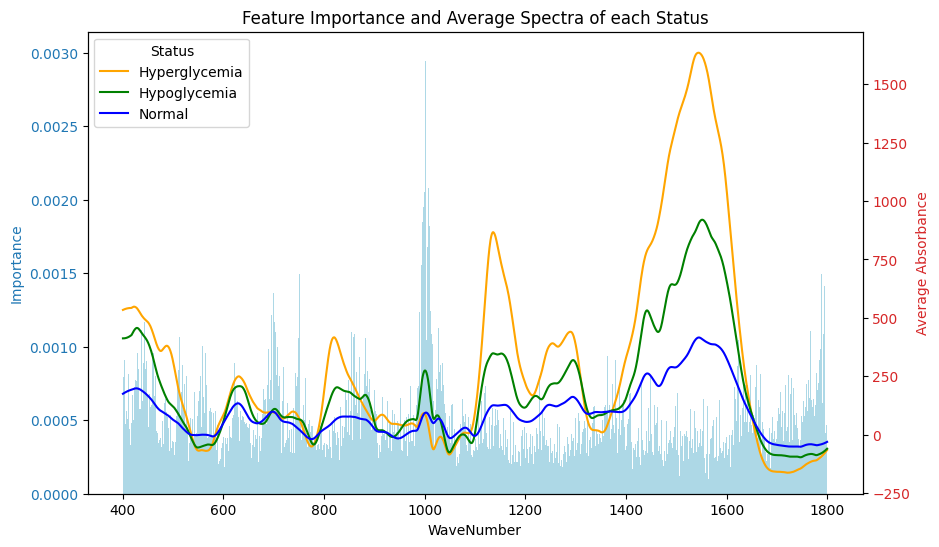

In [28]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()

#### **Cross-Val Importance**

Training the model on the whole dataset may be misleading, lets look at the average feature importance of each WaveNumber across the 10 folds.

In [29]:
from sklearn.model_selection import KFold

# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the KFold object
cv = KFold(n_splits=10, shuffle=True, random_state=1234)

# Initialising an array to store feature importances across all folds
feature_importances = np.zeros(X.shape[1])

# Looping through each split
for train_index, test_index in cv.split(X, y):
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Creating and fitting the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    et.fit(X_train, y_train)
    
    # Accumulating the feature importances
    feature_importances += et.feature_importances_

# Averaging the feature importances across all folds
feature_importances /= 10

# Creating a DataFrame from the feature names and their average importance
feature_names = X.columns
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': feature_importances
})

# Optionally, you might want to sort the DataFrame based on the importances
wavenumber_importance_df = wavenumber_importance_df.sort_values(by='Importance', ascending=False)

# Displaying the DataFrame
wavenumber_importance_df

,WaveNumber,Importance
880,1001.5945,0.002431
879,1000.9111,0.002231
876,998.86102,0.002214
874,997.49432,0.002205
888,1007.0615,0.002156
...,...,...
1120,1165.6036,0.000220
1627,1512.0729,0.000218
1638,1519.59,0.000206
1145,1182.6879,0.000205


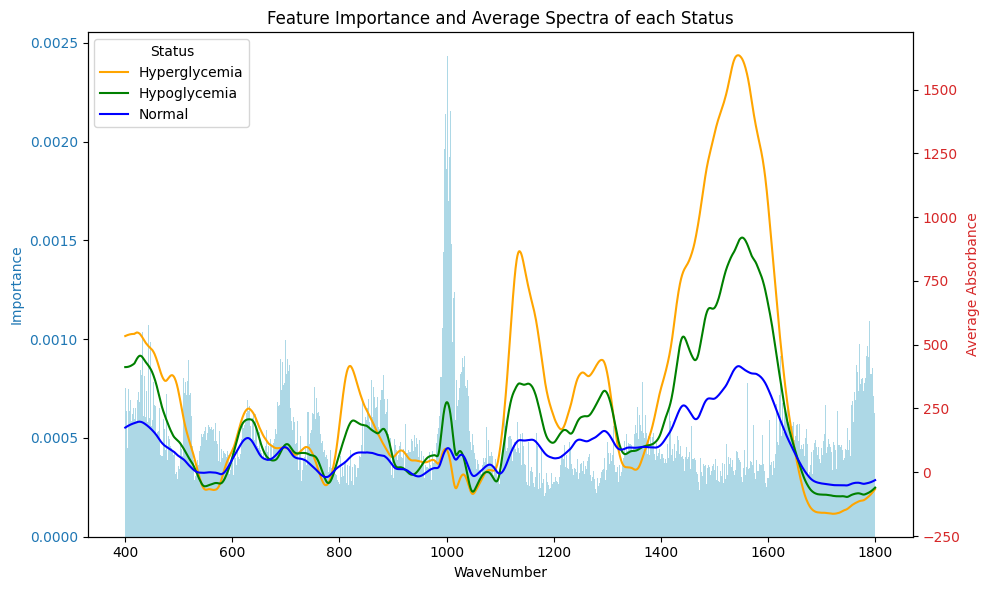

In [30]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# Show the plot
plt.tight_layout()
plt.show()